# Random Forest Modeling

## Predicting the character 

In [49]:
#import necessary libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Importing the Random Forest Classifier module 
from sklearn.ensemble import RandomForestClassifier

#Importing CountVectorizer and TFIDFVectorizer from feature_extraction.text
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn.feature_extraction import text

#Other modules needed 
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import (plot_confusion_matrix, accuracy_score, 
                             classification_report, f1_score)

from nltk.corpus import stopwords


In [24]:
#import the dataset
friends = pd.read_csv('../../Datasets/friends-modeling.csv')
friends.head()

,season,episode,character,dialogue
0,s01,e01,Monica Geller,There's nothing to tell! He's just some guy I ...
1,s01,e01,Joey Tribbiani,"C'mon, you're going out with the guy! There's ..."
2,s01,e01,Chandler Bing,"All right Joey, be nice. So does he have a hum..."
3,s01,e01,Phoebe Buffay,"Wait, does he eat chalk?"
4,s01,e01,Phoebe Buffay,"Just, 'cause, I don't want her to go through w..."


In [25]:
#Make sure no nulls
friends.isnull().sum()

season       0
episode      0
character    0
dialogue     0
dtype: int64

### Make X and y values 

In [26]:
X = friends['dialogue']
y = friends['character']

### Split into Train and Test

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [28]:
X_train.shape

(38472,)

In [29]:
y_train.shape

(38472,)

In [31]:
X_test.shape

(12825,)

In [32]:
y_test.shape

(12825,)

### Baseline Accuracy 

In [33]:
y_train.value_counts(normalize=True)

Rachel Green      0.181847
Ross Geller       0.178571
Chandler Bing     0.167031
Monica Geller     0.165627
Joey Tribbiani    0.160012
Phoebe Buffay     0.146912
Name: character, dtype: float64

### Setting up a Pipe for all Random Forest Modeling

In [60]:
pipe = Pipeline(steps=[('cv', CountVectorizer()),
                       ('rf', RandomForestClassifier(random_state=42))
                      ])

### Modeling: Basic Model with Default Parameters and using CountVectorizer

In [35]:
grid_default = {'cv__stop_words':[None, 'english'],
               'cv__min_df': [50, 100]}

In [36]:
# Instaniate a gridSearch object 
gs_default = GridSearchCV(estimator=pipe, param_grid=grid_default)
gs_default.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('cv', CountVectorizer()),
                                       ('rf',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'cv__min_df': [50, 100],
                         'cv__stop_words': [None, 'english']})

In [37]:
gs_default.best_params_

{'cv__min_df': 50, 'cv__stop_words': None}

In [40]:
gs_default.score(X_train, y_train), gs_default.score(X_test, y_test)

(0.8429767103347889, 0.2658869395711501)

In [41]:
gs_default.best_score_

0.26076102269846313

In [42]:
preds_grid_default = gs_default.predict(X_test)

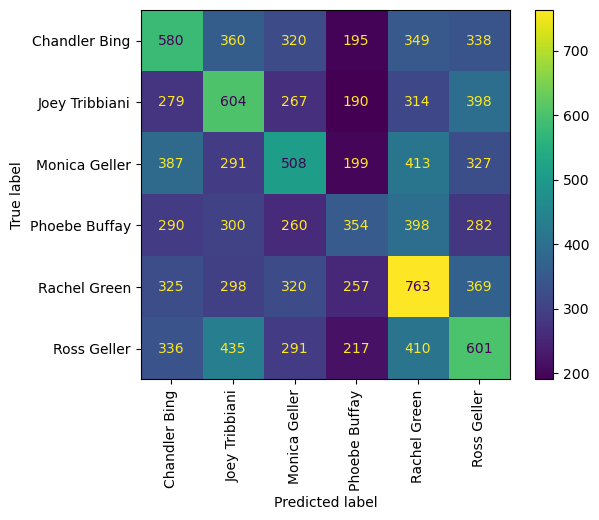

In [48]:
plot_confusion_matrix(estimator=gs_default, X = X_test, y_true=y_test)
plt.xticks(rotation = 90)
plt.show()

In [51]:
print(classification_report(y_test, preds_grid_default))

                precision    recall  f1-score   support

 Chandler Bing       0.26      0.27      0.27      2142
Joey Tribbiani       0.26      0.29      0.28      2052
 Monica Geller       0.26      0.24      0.25      2125
 Phoebe Buffay       0.25      0.19      0.21      1884
  Rachel Green       0.29      0.33      0.31      2332
   Ross Geller       0.26      0.26      0.26      2290

      accuracy                           0.27     12825
     macro avg       0.26      0.26      0.26     12825
  weighted avg       0.26      0.27      0.26     12825



In [86]:
accuracy_score(y_true=y_test, y_pred=preds_grid_default)

0.2658869395711501

In [88]:
#f1_score(y_true=y_test, y_pred=preds_grid_default)

In [85]:
df_default = pd.DataFrame(y_test)

df_default['predictions'] = preds_grid_default
df_default['dialogue'] = X_test
df_default.rename(columns={'character': 'actual'}, inplace=True)
df_default.head(10)

,actual,predictions,dialogue
45809,Rachel Green,Monica Geller,"When you're sick, you do whatever you can to m..."
27777,Rachel Green,Joey Tribbiani,"Well then honey, buy the lamp! Hey, we have th..."
48256,Rachel Green,Rachel Green,She's mine!
36522,Monica Geller,Monica Geller,"Did I miss it? Rachel, I-I want you to know th..."
6393,Phoebe Buffay,Chandler Bing,"OK, look, see, this is him. My mother gave me ..."
25997,Rachel Green,Rachel Green,"But y'know what, if you think it's gonna be ok..."
16641,Chandler Bing,Chandler Bing,"Well, like father, like son."
16009,Chandler Bing,Phoebe Buffay,Could be Casey.
48797,Joey Tribbiani,Phoebe Buffay,"Oh, I know how you feel..."
6594,Monica Geller,Joey Tribbiani,Bobby.


In [57]:
df_default.loc[df_default['actual']!= df_default['predictions']].count()

actual         9415
predictions    9415
dtype: int64

In [58]:
df_default.shape

(12825, 2)

----
### With Parameters!

In [61]:
grid_params_1 = {'cv__stop_words':[None, 'english'],
               'cv__min_df': [50, 100], 
                'rf__n_estimators': [10, 50, 100, 150],
                'rf__max_depth': [10, 25, 50, 75, 100, 150],
                'rf__min_samples_split': [10, 15, 20, 25, 30]}

In [62]:
gs_1 = GridSearchCV(estimator=pipe, param_grid= grid_params_1)
gs_1.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('cv', CountVectorizer()),
                                       ('rf',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'cv__min_df': [50, 100],
                         'cv__stop_words': [None, 'english'],
                         'rf__max_depth': [10, 25, 50, 75, 100, 150],
                         'rf__min_samples_split': [10, 15, 20, 25, 30],
                         'rf__n_estimators': [10, 50, 100, 150]})

In [63]:
gs_1.best_params_

{'cv__min_df': 50,
 'cv__stop_words': None,
 'rf__max_depth': 150,
 'rf__min_samples_split': 15,
 'rf__n_estimators': 150}

In [66]:
gs_1.score(X_train, y_train), gs_1.score(X_test, y_test)

(0.8083281347473488, 0.2801559454191033)

In [65]:
gs_1.best_score_

0.27815017330365355

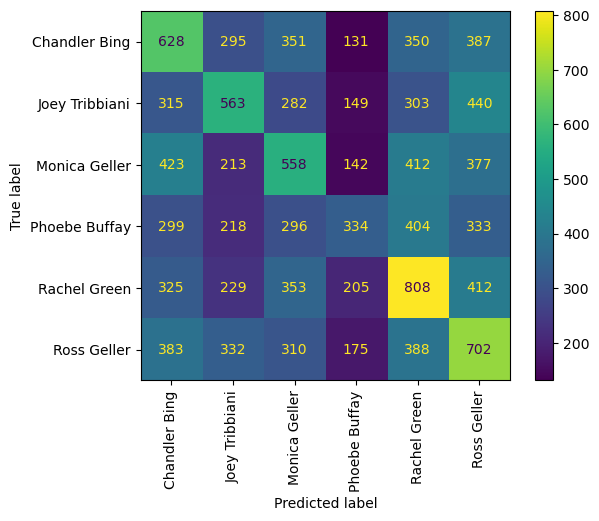

In [71]:
plot_confusion_matrix(estimator=gs_1, X=X_test, y_true=y_test)
plt.xticks(rotation=90)
plt.show()

In [67]:
preds_1 = gs_1.predict(X_test)

In [90]:
print(classification_report(y_true=y_test, y_pred=preds_1))

                precision    recall  f1-score   support

 Chandler Bing       0.26      0.29      0.28      2142
Joey Tribbiani       0.30      0.27      0.29      2052
 Monica Geller       0.26      0.26      0.26      2125
 Phoebe Buffay       0.29      0.18      0.22      1884
  Rachel Green       0.30      0.35      0.32      2332
   Ross Geller       0.26      0.31      0.28      2290

      accuracy                           0.28     12825
     macro avg       0.28      0.28      0.28     12825
  weighted avg       0.28      0.28      0.28     12825



In [91]:
accuracy_score(y_true=y_test, y_pred=preds_1)

0.2801559454191033

In [84]:
df_params_1 = pd.DataFrame(y_test)
df_params_1['predictions'] = preds_1 
df_params_1['dialogue'] = X_test
df_params_1.rename(columns={'character': 'actual'}, inplace=True)
df_params_1.head(10)

,actual,predictions,dialogue
45809,Rachel Green,Monica Geller,"When you're sick, you do whatever you can to m..."
27777,Rachel Green,Joey Tribbiani,"Well then honey, buy the lamp! Hey, we have th..."
48256,Rachel Green,Monica Geller,She's mine!
36522,Monica Geller,Monica Geller,"Did I miss it? Rachel, I-I want you to know th..."
6393,Phoebe Buffay,Chandler Bing,"OK, look, see, this is him. My mother gave me ..."
25997,Rachel Green,Chandler Bing,"But y'know what, if you think it's gonna be ok..."
16641,Chandler Bing,Chandler Bing,"Well, like father, like son."
16009,Chandler Bing,Ross Geller,Could be Casey.
48797,Joey Tribbiani,Phoebe Buffay,"Oh, I know how you feel..."
6594,Monica Geller,Ross Geller,Bobby.


In [81]:
df_params_1.loc[df_params_1['actual']!= df_params_1['predictions']].count()

actual         9232
predictions    9232
dtype: int64

----
Trying out more parameters

In [72]:
#Trying out more parameters!
grid_params_2 = {'cv__stop_words':[None, 'english'],
               'cv__min_df': list(range(0,46)), 
                'rf__n_estimators': list(range(0, 201, 10)),
                'rf__max_depth': list(range(0, 201, 10)),
                'rf__min_samples_split': list(range(0, 51, 5))
}

In [ ]:
gs_2 = GridSearchCV(estimator=pipe, param_grid=grid_params_2)
gs_2.fit(X_train, y_train)